# Neural Network (MLP) Algorithm for Yeast Data
## Import libraries

In [ ]:
#import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from math import floor #, ceil
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

## Preparation of the Data
### Define methods

In [ ]:
def the_train_test_split(X, test_ratio = 0.2):
    if(test_ratio >= 1 or test_ratio <0):
        test_ratio = 0.2
    row, _ = X.shape
    train_count = floor(row * (1-test_ratio))
    train = X[:train_count]
    test = X[train_count:]
    return train, test

### Read Data

In [ ]:
file_name = "yeast.csv"
md = pd.read_csv(file_name)

# md.dropna(inplace = True)
# md.replace('unknown', 0, inplace = True)
md.head()

## Prepare the data
* Shuffle the data
* Separate the input and output variables
* Seperate the data into training and test sets
* Normalize the data


In [ ]:
gl = {}

In [111]:

# Shuffle the data to get more fair representative
md.reindex(np.random.permutation(md.index))

test_ratio = 0.2
X = md.values[:,1:9]
Y = md.values[:,9:]
cat = pd.unique(Y[:,0])

In [112]:
for i in range(X.shape[1]):
    X[:,i] = (X[:,i] - X[:,i].mean())/X[:,i].std()


#
y = np.zeros((len(Y), 10))
for i in range(len(Y)):
    for j in range(10):
        if cat[j] == Y[i]:
            y[i][j] = 1
        else:
            y[i][j] = 0

In [113]:
X_train, X_test = the_train_test_split(X.astype("float64"), test_ratio = test_ratio)
Y_train, Y_test = the_train_test_split(y.astype("float64"), test_ratio = test_ratio)

In [ ]:
class Neural_Network():
    def __init__(self, dimension=None, epochs=100, learning_rate=0.001, act_func ="sigmoid"):
        if dimension is None:
            dimension = [100, 100]
        self.dim = dimension
        self.ep = epochs
        self.lr = learning_rate
        # weight 0: input to 1st hidden
        # weight 1:  1st hidden to  2nd hidden
        # weight len(dim): last hidden to output
        # in total 1+len(dim) weight matrices
        self.weights = {} # they will be defined when the input and output are given

        # actv 0: fired from input layer
        # actv 1: fired from 1st layer
        # actv 1+len(dim): fired from output layer
        self.actv = {} # activation outputs
        # z 0: input to 1st hidden
        # z 1:  1st hidden to  2nd hidden
        # z len(dim): last hidden to output
        # in total 1+len(dim) weight matrices
        self.z = {} # middle values: inputs to next layers
    def forward(self, x):
        self.actv[0] = x
        for i in range(len(self.dim)+1):
            #print("forward actv[",i,"] : ",self.actv[i])
            # bias term is added to each row with broadcasting
            self.z[i] = self.bias_w[i] + np.dot(self.weights[i], self.actv[i])
            #print("forward z[",i,"] : ",self.z[i])

            if i == len(self.dim):
                self.actv[i+1] = self.actFunc(self.z[i], "soft" )
            else:
                self.actv[i+1] = self.actFunc(self.z[i], "sigm" )
            #print("forward actv[",i+1,"] : ",self.actv[i+1], "#")
        return self.actv[1+len(self.dim)]

    def actFunc(self, t, type="sigm"):
        if type == "sigm":
            return self.sigm(t)
        elif type=="sigm-d":
            return self.sigm(t,True)
        elif type=="soft":
            return self.softmax(t)
        else:
            return self.sigm(t)

    def sigm(self, x, derivative=False):
        # todo improve efficiency: e_x = np.exp(-x)
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def back_prop(self, y_exp, y_pred):
        err = y_pred-y_exp
        w_chng = {}
        dimlen = len(self.dim)
        # calculate the update for the last weights
        w_chng[dimlen]= np.multiply(err, self.actv[1+dimlen])
        # calculate changes backwardly
        for i in range(dimlen):
            # e.g. the 1st weights (i.e. w[0])
            # will be updated when i := dimlen-1
            # so that err depends on w[1], previous err and z[0]
            # and change depends on a[1]
            #print( "err: ", err.shape, " ; sw.shape: ",self.weights[dimlen-i].T.shape," ; act.shape: ",self.actFunc(self.z[dimlen-i-1], "sigm-d").shape, "; actv: ", self.actv[dimlen-i].shape )
            err = np.multiply( np.dot(self.weights[dimlen-i].T, err), self.actFunc(self.z[dimlen-i-1], "sigm-d"))
            w_chng[dimlen-i-1] = np.multiply(err, self.actv[dimlen-i])
        #print("w_chng: ", type(w_chng), " : ", w_chng)
        return w_chng

    def update_weights(self, w_changes):
        # why calling items() https://stackoverflow.com/a/62173039/13555389
        global gl
        gl["w_changes"] = w_changes
        gl['wc'] = {}
        for i, chng in w_changes.items():
            #print("uw i=",i, " chng ", chng, " shp: ", self.weights[i].T.shape)
            #print("BEF: ", self.weights[i].T)
            for k in range( len(self.weights[i].T)):
                self.weights[i].T[k] = self.weights[i].T[k] -    self.lr*chng
            #print("AFT: ", self.weights[i].T)

            #w_mtrx = w_mtrx - self.lr*chng

    # THE FOLLOWING FUNCTION IS COPIED IN VERBATIM
    def get_accuracy(self, x_val, y_val):
        self.pred_indices = np.empty([y_val.shape[0], 2], "int" )
        #print("p_i shape:",self.pred_indices.shape)
        global gl
        predictions = []
        i = 0
        for x, y in zip(x_val, y_val):
            output = self.forward(x)
            pred = np.argmax(output)
            exp = np.argmax(y)
            self.pred_indices[i][0], self.pred_indices[i][1]= pred, exp
            #print(output, " : ", pred, " :: ", y, " : ", exp)
            predictions.append(pred == exp)
            i = i+1

        #summed = sum(pred for pred in predictions) / 100.0

        gl['p'] = predictions
        gl['p_i'] = self.pred_indices
        return sum(pred for pred in gl['p'])/len(gl['p'])#np.average(summed)

    def train(self, x_train, y_train, x_test, y_test):
        # initialize weights! etc.!
        # we seperate 1st and last because they depend on the size of x_train and y_train, respectively!
        # weights from input to 1st hidden
        self.weights[0] = np.random.randn(self.dim[0], x_train.shape[1]) * np.sqrt(1. / self.dim[0])
        # set default weights to middle layer weights if there any
        dimlen = len(self.dim)
        for i in range(dimlen - 1):
            self.weights[i+1] = np.random.randn(self.dim[i+1], self.dim[i]) * np.sqrt(1. / self.dim[i+1])
            #print("train: " ,i+1, type( self.weights[i+1]))
        # last weights
        self.weights[dimlen] = np.random.randn(y_train.shape[1], self.dim[dimlen-1]) * np.sqrt(1. / y_train.shape[1])
        #print("train: " ,dimlen, type( self.weights[dimlen]))
        # one bias term for each layer
        self.bias_w = np.ones(1+dimlen) #np.random.randn(1+dimlen)

    # train them all
        start_time = time.time()
        print("Started training!")
        for iteration in range(self.ep):
            for x,y in zip(x_train, y_train):
                output = self.forward(x)
                changes_to_w = self.back_prop(y, output)
                #print("x: ", x, "y: ", y, "o: ", np.argmax(output), " ", output, " /\=", changes_to_w)
                self.update_weights(changes_to_w)

            accuracy = self.get_accuracy(x_test, y_test)
            #if iteration % 10 == 9:
            print('{0}th epoch, {1:.2f} seconds wasted so far, for merely {2}  accuracy'.format(
                iteration+1, time.time() - start_time, accuracy))


In [ ]:
xor_x= np.array([ [0, 0],
     [1, 0],
     [0, 1],
     [1, 1]
     ])
#xor_y =np.array( [ [0], [1], [1],[0]])
xor_y =np.array( [ [1, 0], [0,1], [0,1],[1,0]])

dnn = Neural_Network(dimension=[ 3 ], epochs=10000, learning_rate=1)
dnn.train(xor_x, xor_y, xor_x, xor_y)


In [ ]:
dnn.bias_w


In [ ]:
print(sum(pred for pred in gl['p']) )
print(len(gl['p']))
print(sum(pred for pred in gl['p'])/len(gl['p']))
summed = sum(pred for pred in gl['p']) / 100.0

In [110]:

dnn = Neural_Network(dimension=[ 15, 20 ], epochs=1000, learning_rate=0.1)
dnn.train(X_train, Y_train, X_test, Y_test)

Started training!
1th epoch, 0.45 seconds wasted so far, for merely 0.3434343434343434  accuracy
2th epoch, 0.96 seconds wasted so far, for merely 0.3434343434343434  accuracy
3th epoch, 1.58 seconds wasted so far, for merely 0.3400673400673401  accuracy
4th epoch, 2.04 seconds wasted so far, for merely 0.3367003367003367  accuracy
5th epoch, 2.46 seconds wasted so far, for merely 0.32996632996632996  accuracy
6th epoch, 2.87 seconds wasted so far, for merely 0.31986531986531985  accuracy


KeyboardInterrupt: 

In [ ]:
#print(gl)
for i, j in gl["w_changes"].items():
    print("i: ", i, ", j: ", j)

gl['wc']

0.3434343434343434
['ME3' 'EXC' 'NUC' 'ME3' 'ME3' 'CYT' 'ME3' 'CYT' 'ME1' 'CYT' 'NUC' 'ME3'
 'MIT' 'MIT' 'NUC' 'ME3' 'NUC' 'CYT' 'VAC' 'NUC' 'EXC' 'EXC' 'EXC' 'NUC'
 'CYT' 'CYT' 'CYT' 'ME3' 'CYT' 'CYT' 'CYT' 'CYT' 'MIT' 'NUC' 'NUC' 'NUC'
 'NUC' 'NUC' 'ME1' 'ME3' 'CYT' 'ME3' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'NUC'
 'NUC' 'NUC' 'NUC' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'ME1' 'CYT' 'ME1' 'ME1' 'CYT' 'CYT'
 'NUC' 'NUC' 'NUC' 'NUC' 'NUC' 'NUC' 'VAC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'CYT' 'CYT' 'CYT' 'ME3' 'ME3' 'NUC' 'MIT' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'CYT' 'CYT' 'NUC' 'ME2' 'CYT' 'CYT' 'CYT' 'CYT' 'MIT' 'NUC' 'NUC'
 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'ME3' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT'
 'NUC' 'ME3' 'NUC' 'NUC' 'NUC' 'CYT' 'NUC' 'CYT' 'CYT' 'CYT' 'ME3' 'NUC'
 'VAC' 'MIT' 'CYT' 'VAC' 'VAC' 'VAC' 'VAC' 'VAC' 'VAC' 'VAC' 'VAC' 'VAC'
 'VAC' 'VAC' 'CYT' 'CYT' 'CYT' '

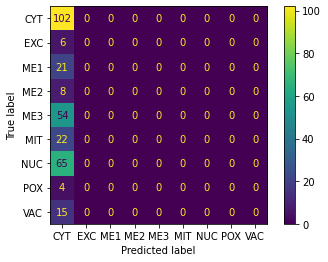

In [114]:
# test accuracy
print(dnn.get_accuracy(X_test, Y_test))
pred_class = cat[gl['p_i'][:,0]]
exp_class = cat[gl['p_i'][:,1]]
print(exp_class)
print(pred_class)
ConfusionMatrixDisplay.from_predictions(exp_class, pred_class)


0.3041280539174389
297
['MIT' 'MIT' 'MIT' ... 'ME3' 'EXC' 'ME3']
['CYT' 'CYT' 'CYT' ... 'CYT' 'CYT' 'CYT']


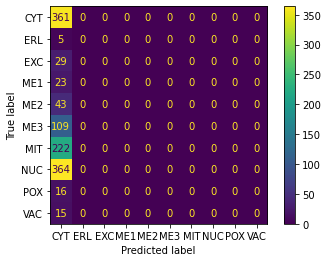

In [115]:
# training accuracy
print(dnn.get_accuracy(X_train, Y_train))
print(Y_test.shape[0])
pred_class = cat[gl['p_i'][:,0]]
exp_class = cat[gl['p_i'][:,1]]
print(exp_class)
print(pred_class)
ConfusionMatrixDisplay.from_predictions(exp_class, pred_class)


In [ ]:
for i in range (3):
    print("type z[",i,"] : ", type(dnn.z[i]))
    print("shape z[",i,"] : ",dnn.z[i].shape)
    #print("forward z[",i,"] : ",dnn.z[i])
    print("")
    print("type actv[",i,"] : ", type(dnn.actv[i]))
    print("shape actv[",i,"] : ",dnn.actv[i].shape)
    #print("forward actv[",i,"] : ",dnn.actv[i])
    print("")

    print("type weights[",i,"] : ", type(dnn.weights[i]))
    print("shape weights[",i,"] : ",dnn.weights[i].shape)
    #print("forward weights[",i,"] : ",dnn.weights[i])
    print("-----------------\n")

i = 3
print("type actv[",i,"] : ", type(dnn.actv[i]))
print("shape actv[",i,"] : ",dnn.actv[i].shape)
print("forward actv[",i,"] : ",dnn.actv[i])
print("")

In [ ]:
print(type(dnn.weights[0]) ) #, ", shape: "dnn.weights[0].shape)
print(type(dnn.weights[1]) ) #, ", shape: "dnn.weights[1].shape)
print(type(dnn.weights[2]) ) #, ", shape: "dnn.weights[2].shape)

In [ ]:
dnn.weights[0]

In [ ]:

dnn.weights[1]

In [ ]:

dnn.weights[2]